# Argument Quality Prediction

El objetivo de este proyecto se basa en crear modelos de machine para clasificar los elementos argumentativos en los textos escritos por estudiantes como "efectivos", "adecuados" o "ineficaces". Esta clasificación automatizada tiene como objetivo proporcionar una mejor retroalimentación a los estudiantes, para así ellos puedan mejorar sus habilidades de escritura.


In [140]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna
from optuna.trial import TrialState
import joblib

In [123]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Data Loading and Initial Inspection

In [124]:
train_df = pd.read_csv('data/train_preprocessed.csv')
# Display the first few rows
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text_length,text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317,hi im isaac im going writing face mars natural...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,210,perspective think face natural landform dont t...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,105,think face natural landform life mars descover...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,362,life mars would know reason think natural land...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,101,people thought face formed alieans thought lif...


In [141]:
# Check for null values
print("Null values before dropping:")
print(train_df.isnull().sum())

Null values before dropping:
discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
text_length                0
text                       0
tokens                     0
dtype: int64


In [142]:
# Drop rows with null values
train_df = train_df.dropna()

In [143]:
print("\nNull values after dropping:")
print(train_df.isnull().sum())


Null values after dropping:
discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
text_length                0
text                       0
tokens                     0
dtype: int64


## 2. Enhanced Preprocessing

In [144]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [147]:
# Define a custom tokenizer using NLTK's word_tokenize and additional preprocessing
def custom_tokenizer(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [148]:
# Apply the tokenizer to the text data
train_df['tokens'] = train_df['text'].apply(custom_tokenizer)

# Display tokenized text
train_df[['text', 'tokens']].head()

,text,tokens
0,hi im isaac im going writing face mars natural...,"[hi, im, isaac, im, going, writing, face, mars..."
1,perspective think face natural landform dont t...,"[perspective, think, face, natural, landform, ..."
2,think face natural landform life mars descover...,"[think, face, natural, landform, life, mars, d..."
3,life mars would know reason think natural land...,"[life, mars, would, know, reason, think, natur..."
4,people thought face formed alieans thought lif...,"[people, thought, face, formed, alieans, thoug..."


## 3. Feature Engineering

In [149]:
# Initialize the TF-IDF Vectorizer with the custom tokenizer
tfidf = TfidfVectorizer(
    max_features=10000,  # Number of features
    ngram_range=(1,3),   # Including up to trigrams
    tokenizer=custom_tokenizer,
    token_pattern=None    # To use the custom tokenizer
)


In [150]:
# Fit and transform the text data
X_text = tfidf.fit_transform(train_df['text'])

In [151]:
from sklearn.decomposition import TruncatedSVD
# Reduce dimensionality with Truncated SVD
svd = TruncatedSVD(n_components=300, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

In [135]:
# Scale the 'text_length' feature
scaler = StandardScaler()
X_length = scaler.fit_transform(train_df[['text_length']])

In [136]:
# One-Hot Encode the 'discourse_type' feature
ohe = OneHotEncoder(drop='first', sparse_output=True)
X_discourse = ohe.fit_transform(train_df[['discourse_type']])

In [161]:
# Concatenate all features
import scipy.sparse as sp
X = sp.hstack([X_text_reduced, X_length, X_discourse]).tocsr()

In [ ]:
# Encode the labels
le = LabelEncoder()
y = le.fit_transform(train_df['discourse_effectiveness'])

## 4. Train-Test Split

In [162]:
# Split the data into training and validation sets **before** applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')

Training samples: 29405
Validation samples: 7352


## 5. Handling Class Imbalance with SMOTE

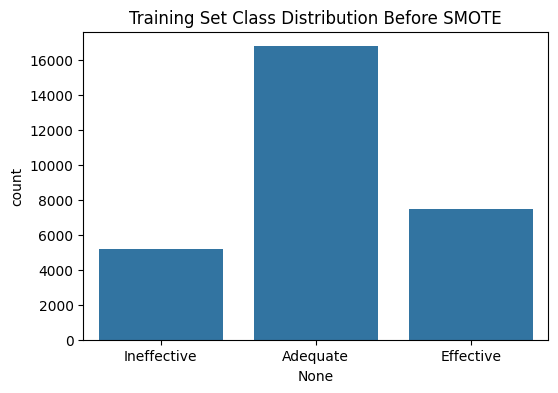

In [163]:
# Visualize class distribution before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Series(y_train).map(lambda x: le.inverse_transform([x])[0]))
plt.title('Training Set Class Distribution Before SMOTE')
plt.show()

In [164]:
# Apply SMOTE **only on the training set**
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

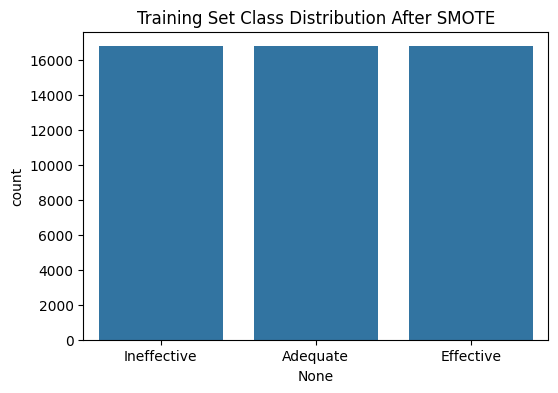

In [165]:
# Visualize class distribution after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=pd.Series(y_train_resampled).map(lambda x: le.inverse_transform([x])[0]))
plt.title('Training Set Class Distribution After SMOTE')
plt.show()

## 6. PyTorch Dataset and DataLoader

In [166]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.toarray()).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [167]:
# Create Dataset objects
train_dataset = TextDataset(X_train_resampled, y_train_resampled)
val_dataset = TextDataset(X_val, y_val)

In [168]:
# Create DataLoader objects
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 7. Define the PyTorch Model

In [169]:
class NeuralNetPyTorch(nn.Module):
    def __init__(self, input_size, num_classes, hidden_sizes, dropout_rates):
        super(NeuralNetPyTorch, self).__init__()
        layers = []
        in_size = input_size
        for hidden_size, dropout_rate in zip(hidden_sizes, dropout_rates):
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_size = hidden_size
        layers.append(nn.Linear(in_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

## 8. Define Focal Loss

In [170]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-class classification
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Can be a tensor or None
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        logpt = -self.ce(inputs, targets)
        pt = torch.exp(logpt)
        focal_loss = -((1 - pt) ** self.gamma) * logpt
        if self.alpha is not None:
            if isinstance(self.alpha, (list, np.ndarray)):
                alpha = self.alpha[targets]
                focal_loss = alpha * focal_loss
            else:
                focal_loss = self.alpha * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

---

In [176]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


---

## 9. Hyperparameter Optimization with Optuna

In [174]:
def objective(trial):
    # Suggest hyperparameters
    hidden_layer1 = trial.suggest_int('hidden_layer1', 512, 2048, step=256)
    hidden_layer2 = trial.suggest_int('hidden_layer2', 256, 1024, step=256)
    dropout1 = trial.suggest_float('dropout1', 0.3, 0.7, step=0.1)
    dropout2 = trial.suggest_float('dropout2', 0.3, 0.7, step=0.1)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    gamma = trial.suggest_float('gamma', 1.0, 3.0, step=0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Define model
    hidden_sizes = [hidden_layer1, hidden_layer2]
    dropout_rates = [dropout1, dropout2]
    model = NeuralNetPyTorch(
        input_size=X_train_resampled.shape[1],
        num_classes=len(le.classes_),
        hidden_sizes=hidden_sizes,
        dropout_rates=dropout_rates
    ).to(device)

    # Define loss function
    criterion = FocalLoss(gamma=gamma)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=2,
                                                     verbose=False)

    # Training parameters
    epochs = 30
    patience_early = 5
    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_running_loss / val_total
        val_epoch_acc = val_correct / val_total

        # Step the scheduler
        scheduler.step(val_epoch_loss)

        # Early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
            # Optional: Save the model state within Optuna
        else:
            patience_counter += 1
            if patience_counter >= patience_early:
                break

    # After training, evaluate on validation set
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.numpy())

    # Calculate metrics
    f1 = f1_score(val_labels, val_preds, average='weighted')

    # Objective is to maximize weighted F1-score
    return f1

## 10. Running the Optimization Study

In [177]:
# Create an Optuna study
study = optuna.create_study(direction='maximize', study_name='PyTorch_Text_Classification_Optimized')
study.optimize(objective, n_trials=50, timeout=3600)  # Adjust n_trials and timeout as needed

[I 2024-11-14 00:26:01,105] A new study created in memory with name: PyTorch_Text_Classification_Optimized
C:\Users\chama\AppData\Local\Temp\ipykernel_34216\538497269.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\chama\AppData\Local\Temp\ipykernel_34216\538497269.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
c:\Users\chama\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 20

## 11. Analyzing the Optimization Results

In [ ]:
# Initialize the model
input_size = X_train.shape[1]
num_classes = len(le.classes_)
model = NeuralNetPyTorch(input_size, num_classes)

In [ ]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f'Using device: {device}')

Using device: cpu


## 8. Define Loss Function and Optimizer

In [ ]:
# Use CrossEntropyLoss with class weights
# criterion = FocalLoss(gamma=2)

In [ ]:
# Option 2: Use CrossEntropyLoss with class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Use Adam optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Define Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=3,
                                                 verbose=True)

c:\Users\chama\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 9. Training the Model

In [ ]:
# Define the number of epochs and early stopping parameters
epochs = 50
patience = 7
best_val_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')

    # Step the scheduler
    scheduler.step(val_epoch_loss)

    # Check for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break


Epoch 1/50
Train Loss: 0.8125 | Train Acc: 0.6201
Val Loss: 0.7221 | Val Acc: 0.6715
Epoch 2/50
Train Loss: 0.7144 | Train Acc: 0.6765
Val Loss: 0.6807 | Val Acc: 0.6976
Epoch 3/50
Train Loss: 0.6685 | Train Acc: 0.7042
Val Loss: 0.6558 | Val Acc: 0.7076
Epoch 4/50
Train Loss: 0.6291 | Train Acc: 0.7248
Val Loss: 0.6235 | Val Acc: 0.7249
Epoch 5/50
Train Loss: 0.5964 | Train Acc: 0.7393
Val Loss: 0.5969 | Val Acc: 0.7370
Epoch 6/50
Train Loss: 0.5630 | Train Acc: 0.7530
Val Loss: 0.5842 | Val Acc: 0.7449
Epoch 7/50
Train Loss: 0.5366 | Train Acc: 0.7698
Val Loss: 0.5628 | Val Acc: 0.7533
Epoch 8/50
Train Loss: 0.5040 | Train Acc: 0.7846
Val Loss: 0.5538 | Val Acc: 0.7595
Epoch 9/50
Train Loss: 0.4874 | Train Acc: 0.7958
Val Loss: 0.5347 | Val Acc: 0.7714
Epoch 10/50
Train Loss: 0.4611 | Train Acc: 0.8050
Val Loss: 0.5311 | Val Acc: 0.7745
Epoch 11/50
Train Loss: 0.4430 | Train Acc: 0.8149
Val Loss: 0.5305 | Val Acc: 0.7761
Epoch 12/50
Train Loss: 0.4282 | Train Acc: 0.8207
Val Loss: 0.

## 10. Load the Best Model

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\chama\AppData\Local\Temp\ipykernel_34216\1514978434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

## 11. Evaluation

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
# Get predictions on the validation set
y_pred, y_true = evaluate_model(model, val_loader)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Weighted F1-Score: {f1:.4f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=le.classes_))

Validation Accuracy: 0.8063
Validation Weighted F1-Score: 0.8045
Classification Report:
              precision    recall  f1-score   support

    Adequate       0.74      0.68      0.71      4194
   Effective       0.85      0.86      0.85      4195
 Ineffective       0.82      0.88      0.85      4195

    accuracy                           0.81     12584
   macro avg       0.80      0.81      0.80     12584
weighted avg       0.80      0.81      0.80     12584



## 12. Confusion Matrix

In [ ]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

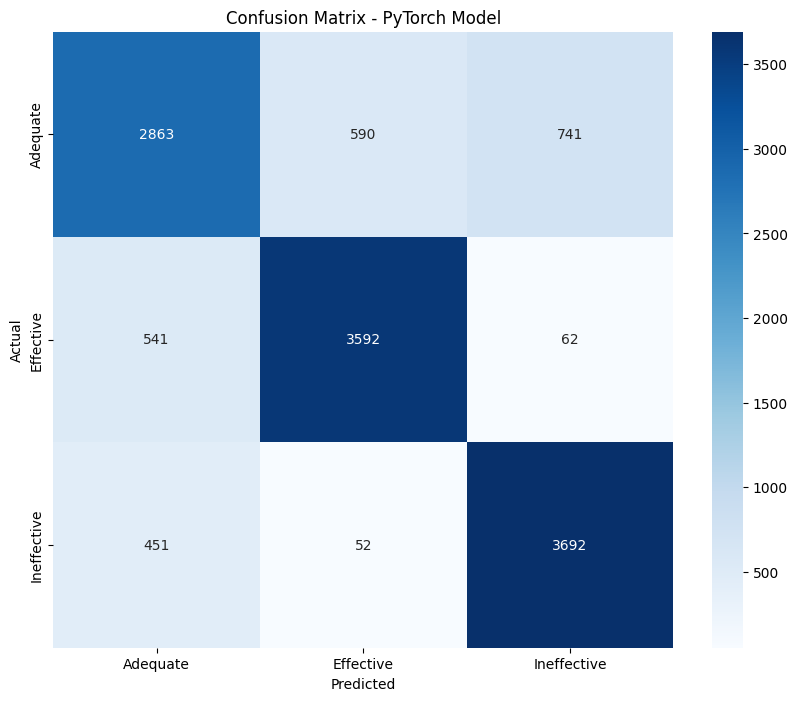

In [ ]:
plot_confusion(y_true, y_pred, 'Confusion Matrix - PyTorch Model')

## 13. Training Curves

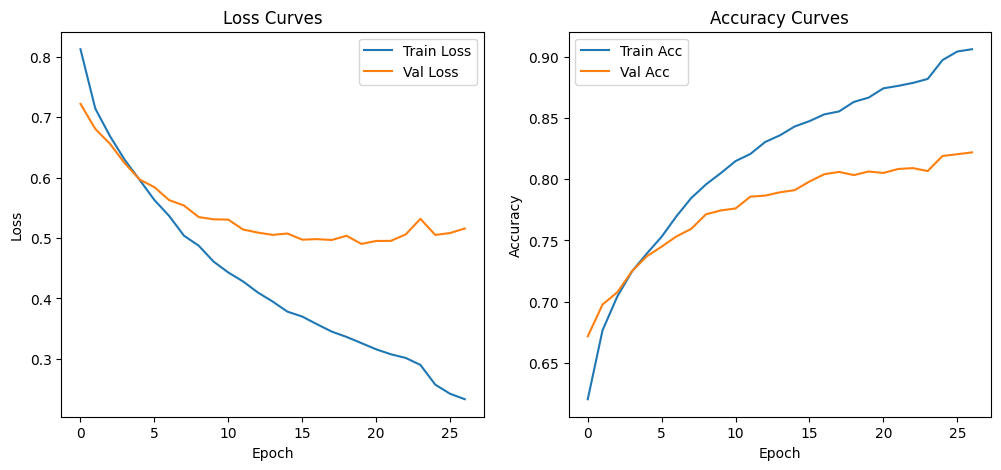

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

## 14. Saving the Model and Vectorizer

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'pytorch_text_model_enhanced.pth')

In [ ]:
# Save the TF-IDF vectorizer and SVD
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer_enhanced.joblib')
joblib.dump(svd, 'truncated_svd_enhanced.joblib')

# Save the label encoder
joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']